**Задача** - провести анализ клиентской базы и подготовить план по удержанию клиентов.

Импортируем нужные библиотеки 

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 
import plotly.express as px
import matplotlib.pyplot as plt
from plotly import graph_objects as go
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, silhouette_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

Выгружаем данные 

In [2]:
data = pd.read_csv('gym_churn.csv')

Изучаем вид данных

In [3]:
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Все данные численные, что упрощает предобработку данных для машинного обучения. Пропусков нет. Для удобства переименуем столбцы

In [5]:
data.columns = [
    'gender', 
    'near_location', 
    'partner', 
    'promo_friends', 
    'phone', 
    'contract_period', 
    'group_visits', 
    'age', 
    'avg_additional_charges_total',
    'month_to_end_contract',
    'lifetime',
    'avg_class_frequency_total',
    'avg_class_frequency_current_month',
    'churn'
]

Посмотрим на средние значения и стандартные отклонения по всему датасету

In [6]:
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Явно выделяющегося не замечено. Посмотрим на разницу средних по факту оттока

In [7]:
data.groupby(['churn']).mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Судя по средним значениям у людей, которые остаются в фитнес-зале, относительно более близкое местоположение, больше доля сотрудников компании-партнеров клуба, больше доля людей, которые оплачивали первый абонемент по промокоду, значительно дольше длительность текущего контрактного периода, больше ходят группами. И также чуточку старше и чуть больше платят за дополнительные услуги в среднем.

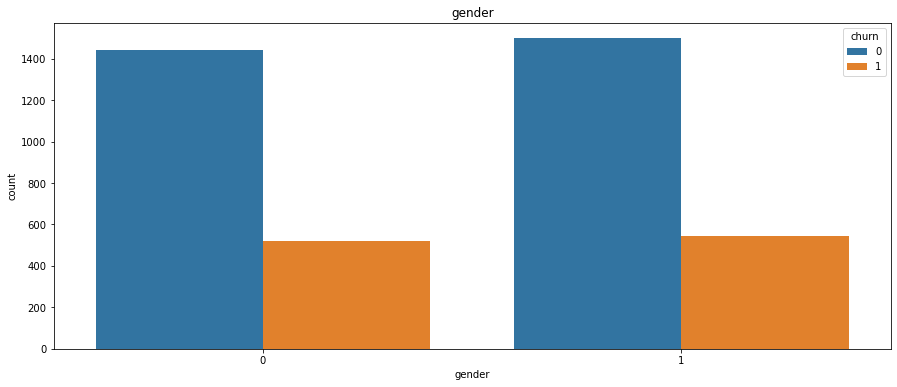

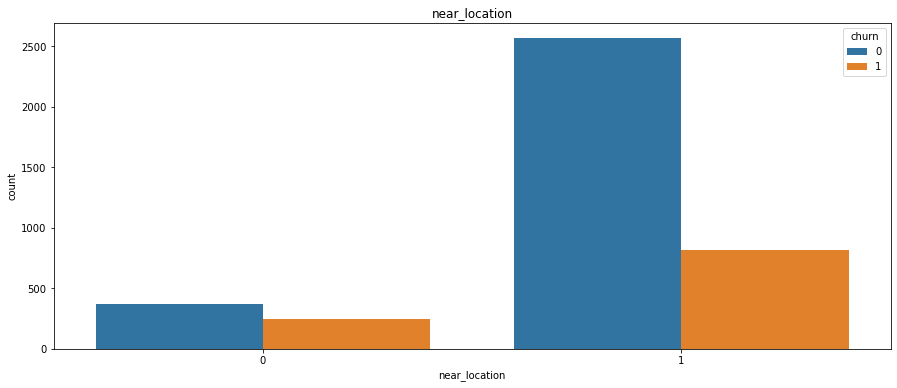

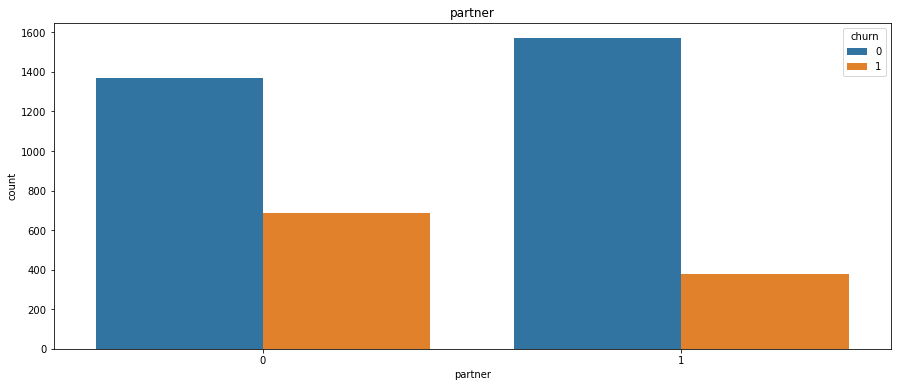

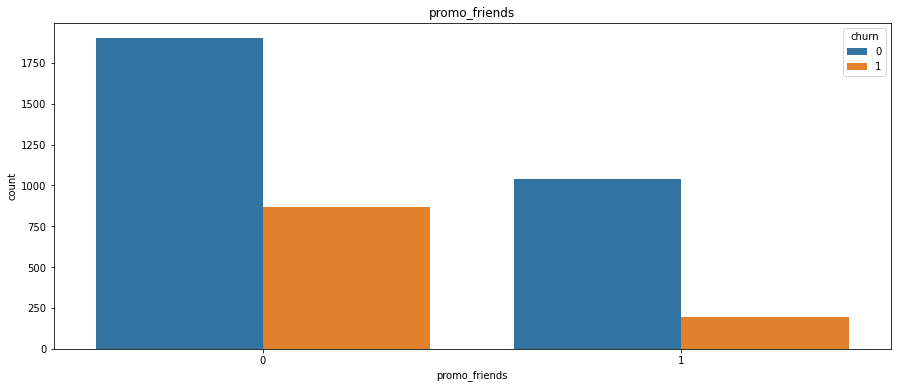

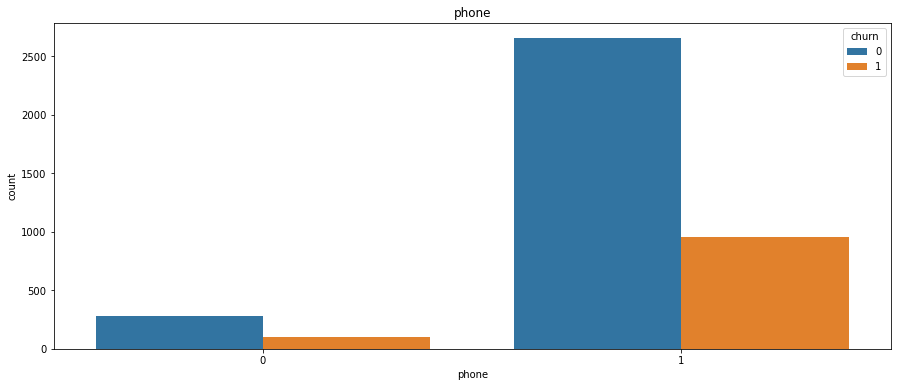

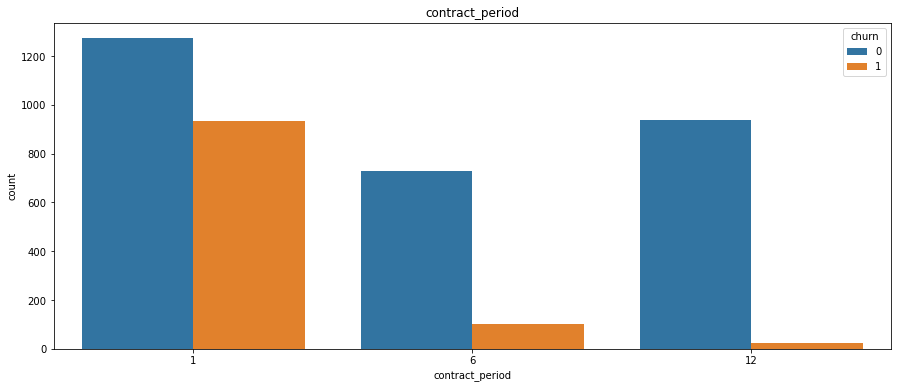

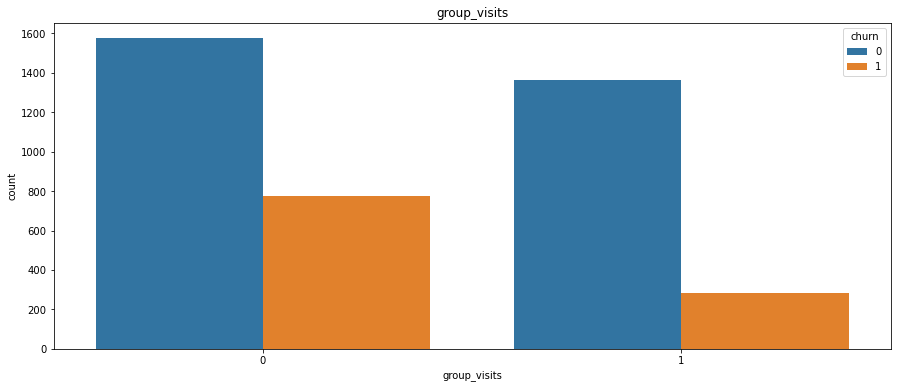

In [8]:
columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits']
def make_barplot(data, column):
    column_data = data[[column, 'churn']].reset_index()
    column_data = column_data.groupby([column, 'churn']).agg('count')
    column_data.columns = ['count']
    column_data.reset_index(inplace=True)
    #fig = px.bar( 
       #column_data, x=column, y='count', title=column, color='churn', text='count'
    #)
    #fig.show()  На гитхабе библиотека plotly не отображается - поэтому используем библиотеку seaborn
    plt.figure(figsize=(15,6))
    plt.title(column)
    sns.barplot(data=column_data, x=column, y='count', hue='churn')

for column in columns:
    make_barplot(data, column)

По графикам можно сделать вывод, что пол не играет роли в оттоке. В остальном: near_location - Подавляющее кол-во клиентов с близким местоположением, но и среди них почти четверть с оттоком. 
promo - Стоит обратить внимание на промокоды. С их применением приглашенные люди гораздо чаще остаются, чем сами пришедшие.
contract_period - Очевидно, что на длительный период люди гораздо чаще остаются, поэтому стоит их стимулировать брать длительные абонементы.
group_visits - Также более лояльны клиенты, если ходят группами

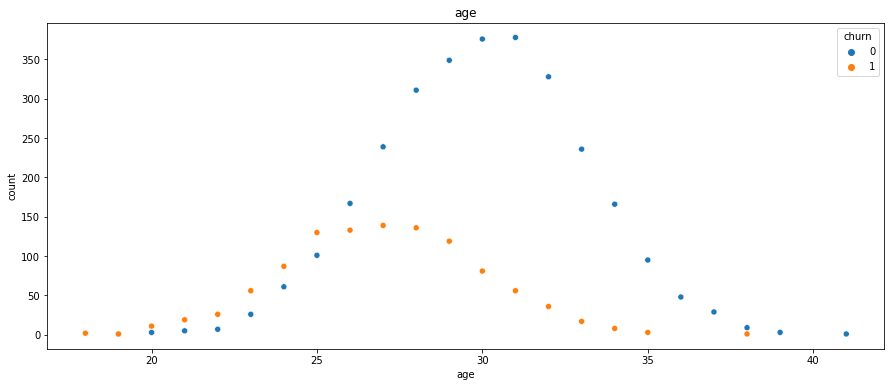

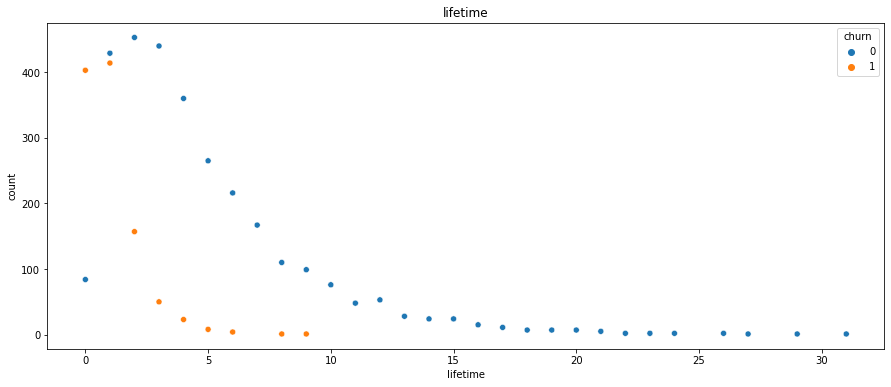

In [9]:
scatter_columns = ['age', 'lifetime']
def make_scatterplot(data, column):
    column_data = data[[column, 'churn']].reset_index()
    column_data = column_data.groupby([column, 'churn']).agg('count')
    column_data.columns = ['count']
    column_data.reset_index(inplace=True)
    #fig = px.scatter(
        #column_data, x=column, y='count', title=column, color='churn'
    #)
    #fig.show() На гитхабе библиотека plotly не отображается - поэтому используем библиотеку seaborn
    plt.figure(figsize=(15,6))
    plt.title(column)
    sns.scatterplot(data=column_data, x=column, y='count', hue='churn')
    
for column in scatter_columns:
    make_scatterplot(data, column)

Как и ожидалось: подавляющее большинство 'отваливающихся' клиентов в пределах первых трех месяцев. С возрастом ситуация интереснее: среди тех, кто остается, большинству около 30 лет, но и более молодые тоже посещают, но среди них гораздо чаще тех, кто уходит. Надо это учесть в финальном выводе.

Построим матрицу корреляций

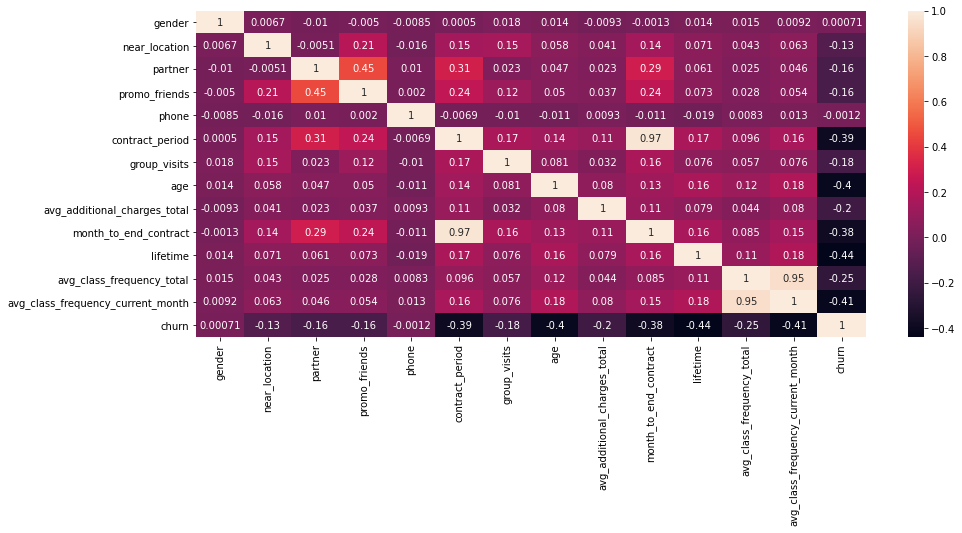

In [10]:
corr_data = data.corr()
plt.figure(figsize=(15, 6))
sns.heatmap(corr_data, annot=True)
plt.show()

Судя по матрице корреляций, сильных зависимостей между признаками и целевой переменной оттока - нет. Это облегчает работу для машинного обучения и значительно повысит шанс от переобучения.

Перейдем к построению *модели бинарной классификации клиентов.* Разобьем данные на обучающую и валидационную

In [11]:
X = data.drop(['churn'], axis=1)
y = data['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

Обучим модель двумя способами: 1)логистической регрессией, 2)случайнм лесом

In [12]:
def print_all_metrics(y_true, y_pred, y_proba, title):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]
print_all_metrics(y_test, lr_predictions, lr_probabilities, title='Метрики для модели логистической регрессии')

rf_model = RandomForestClassifier(n_estimators = 100, random_state=0)
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]
print_all_metrics(y_test, rf_predictions, rf_probabilities, title='Метрики для модели случайного леса')

threshold = 0.6

custom_lr_predictions = [0 if i < threshold else 1 for i in lr_probabilities]
print_all_metrics(y_test, custom_lr_predictions, lr_probabilities, title='Метрики для модели логистической регрессии c кастомным порогом')

custom_rf_predictions = [0 if i < threshold else 1 for i in rf_probabilities]
print_all_metrics(y_test, custom_rf_predictions, rf_probabilities, title='Метрики для модели случайного леса c кастомным порогом')

Метрики для модели логистической регрессии
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83
	F1: 0.84
	ROC_AUC: 0.97
Метрики для модели случайного леса
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.81
	F1: 0.83
	ROC_AUC: 0.97
Метрики для модели логистической регрессии c кастомным порогом
	Accuracy: 0.93
	Precision: 0.91
	Recall: 0.81
	F1: 0.86
	ROC_AUC: 0.97
Метрики для модели случайного леса c кастомным порогом
	Accuracy: 0.90
	Precision: 0.85
	Recall: 0.72
	F1: 0.78
	ROC_AUC: 0.97


В целом метрика площади под кривой ошибок (roc_auc), которая оценивает качество модели классификатора, на одном уровне (0.97). Единственный момент, что с кастомным порогом для модели случайного леса модель работает относительно хуже остальных.
Доля правильных ответов в обоих случаях до кастомного порога равна 92%, что вполне неплохо. Однако логистическая регрессия оказалась чуточку лучше в точности и полноте - 85% и 83% соответственно.
Применив кастомный порог в 0.6, модель логистической регрессии прибавила в доле правильный ответов (с 92 до 93%) и значительно повысила точность (с 85% до 91%), лишь потеряв немного в полноте (с 83% до 81%). 

И наконец проведем кластеризацию клиентов. Начинаем со стандартизации данных

In [13]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)
linked = linkage(X_sc, method='ward')

Построим дендрограмму

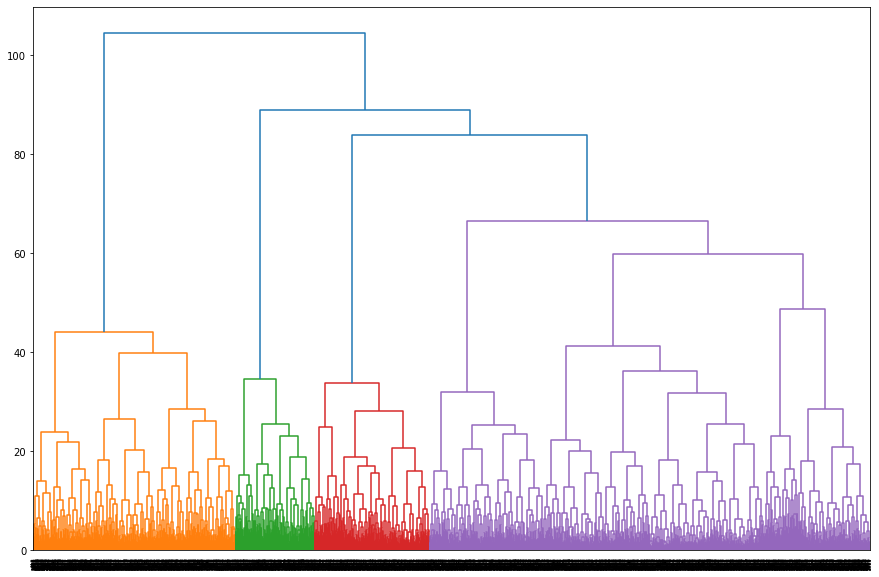

In [14]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

Дендромграмма отрисовывает нам четыре кластера, но четвертый чересчур большой, поэтому мы поделим их на пять. Найдем средние значения признаков по кластерам

In [15]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_sc)
data['cluster_km'] = labels
data.groupby(['cluster_km']).mean().sort_values(by='churn', ascending=False)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723


Первые два кластера, у которых относительно высокий средний показатель оттока, имеют диаметрально противоположные показатели по местоположению к фитнес-залу. Да, у них средние показатели оттока около половины, но это уже потенциальная группа риска. Стоит рассмотреть по дополнительным признакам

In [16]:
def show_clusters(df, x_name, y_name, cluster_name):
    #df = df.query('cluster_km == 0 or cluster_km == 1')
    plt.figure(figsize=(12, 10))
    sns.scatterplot(
        data=df, x=x_name, y=y_name, hue = cluster_name, palette = 'Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()


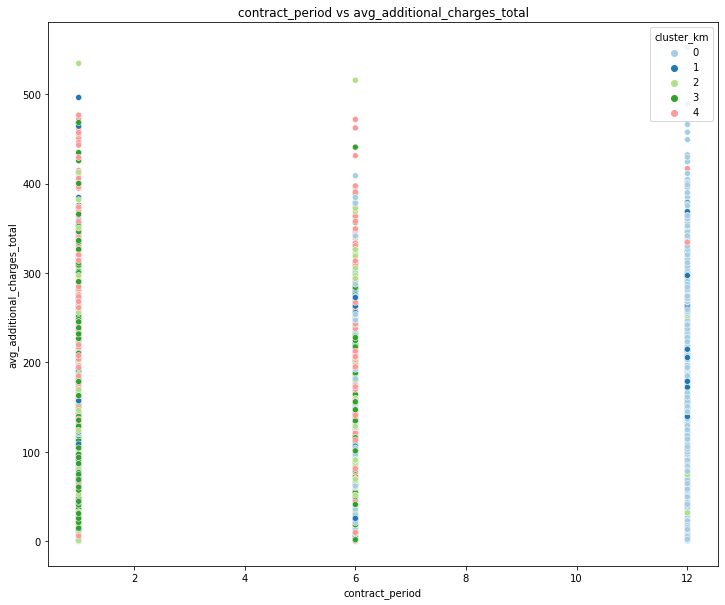

In [17]:
show_clusters(data, 'contract_period', 'avg_additional_charges_total', 'cluster_km')

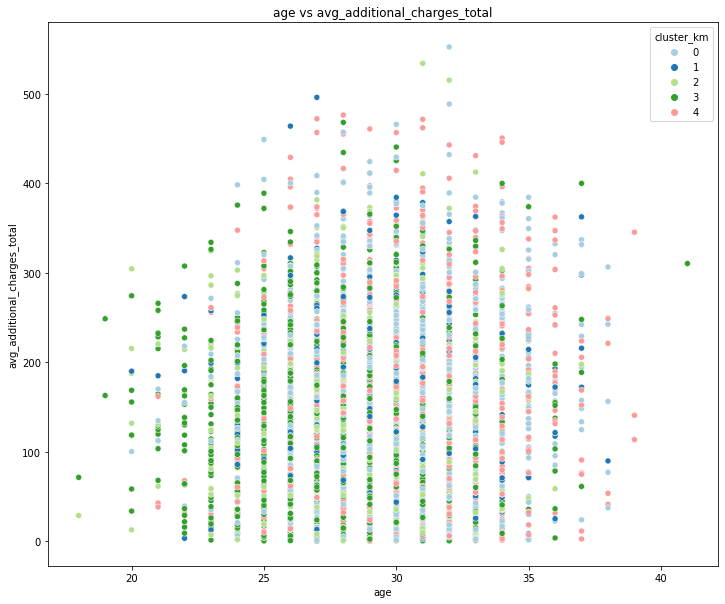

In [18]:
show_clusters(data, 'age', 'avg_additional_charges_total', 'cluster_km')

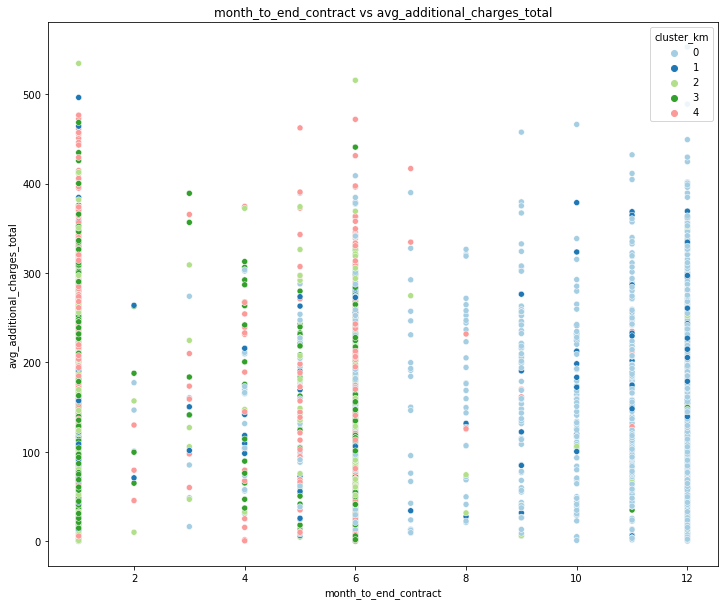

In [19]:
show_clusters(data, 'month_to_end_contract', 'avg_additional_charges_total', 'cluster_km')

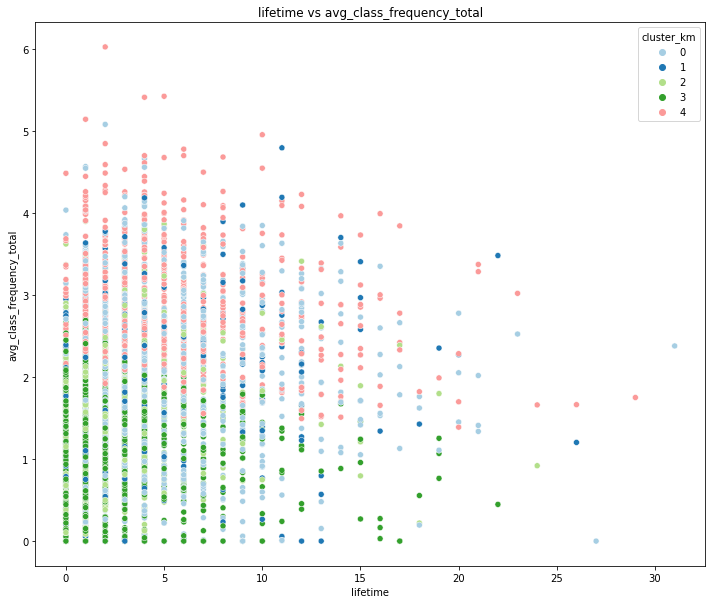

In [20]:
show_clusters(data, 'lifetime', 'avg_class_frequency_total', 'cluster_km')

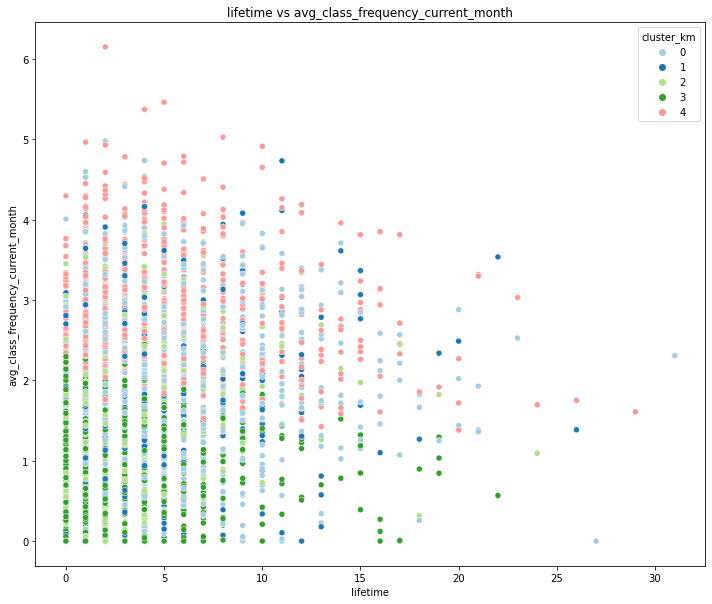

In [21]:
show_clusters(data, 'lifetime', 'avg_class_frequency_current_month', 'cluster_km')

Какая-то логика в кластеризации присутствует, но не настолько явная - посмотрим, что скажет метод *silhouette_score*

In [22]:
print('Silhouette_score: {:.2f}'.format(silhouette_score(X_sc, labels)))

Silhouette_score: 0.14


Силуэт-скор, равный 0,14, говорит о том, что в целом проблематично по имеющимся данным выявить четкие кластеры клиентов.

В общем и целом можно сделать **несколько выводов** по всему исследованию:

1) Более **лояльны** те клиенты, кто берет **более длительный абонемент.**

2) В **третьем кластере** клиентов, которые **близко живут** к фитнес-залу, гораздо **реже ходят в месяц** и относительно **самый низкий средний показатель длительности контракта**. 

3) Во **втором кластере**, которые наоборот **далеко живут** от фитнеса, **меньше** людей, пришедших **по промокоду**, и **меньше групповых посещений** среди всех кластеров.

4) Оба кластера риска имеют в среднем более **молодой** контингент клиентов и **самый низкий средний показатель оплаты доп услуг**

**Рекомендации:**

1) Разработать стратегию привлечения клиентов на более **длительный срок** с поощрением **групповых визитов** и приобретением **доп услуг** в зависимости от длительности абонемента

2) Подумать о промокодах по разделению по районам: если приглашенный клиент из **другого района**, то первый месяц **больше привилегий**